##### Modules

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

import numpy as np
from data_handler import DataHandler
from droplet_model import DropletModel, ReparameterisedDropletModel
from parameter_fitting import ParameterFitting
from plots import Plots
import matplotlib.pyplot as plt
import pints
import pints.plot
from scipy.integrate import odeint
from numba import njit
import seaborn as sns
from cycler import cycle


##### Likelihoods

In [ ]:
class AdditiveNormalSigmaMLEIndicatorLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, zero_tol=0.0):
        """
        Parameters
        ----------
        problem : pints.Problem
            the PINTS problem that provides .n_outputs(), .n_times(), .evaluate(x) etc.
        zero_tol : float
            any sse <= zero_tol is treated as "zero error" and that output is ignored.
            Use 0.0 to ignore only exact zeros or something like 1e-16 for numerical safety.
        """
        super(AdditiveNormalSigmaMLEIndicatorLogLikelihood, self).__init__(problem)
        self._no = problem.n_outputs()
        self._np = problem.n_parameters()
        self._nt = problem.n_times()
        self._zero_tol = float(zero_tol)



    def __call__(self, x):
        # evaluate residuals: shape (nt, no) or broadcasting equivalent as in your code
        error = self._values - self._problem.evaluate(x)

        # sum of squared errors per output
        sse = np.sum(error**2, axis=0) / float(self._nt)  # length = no

        # mask outputs that have non-zero SSE (use numeric tolerance)
        mask = sse > self._zero_tol
        k = int(np.count_nonzero(mask))  # number of included outputs

        # if nothing remains, return -inf (log-likelihood impossible under this param)
        if k == 0:
            return -np.inf

        # use only positive/valid SSEs
        sse_valid = sse[mask]

        # log term from MLE substitution: -0.5 * sum(log(sse_valid))
        log_term = -0.5 * np.sum(np.log(sse_valid))

        # offset depends on how many outputs were included
        offset = -0.5 * k * self._nt * (np.log(2.0 * np.pi) + 1.0)

        return offset + log_term

##### Functions

In [3]:
def get_sigma_MLEs(
    model, 
    data, 
    mle_params, 
    data_times, 
    noise_model="additive normal"
):

    opt_model_sol = model.simulate(mle_params, data_times)
    residuals = opt_model_sol - data

    n_t = len(data_times)

    if noise_model == "additive normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2, axis=0))

    elif noise_model == "multiplicative normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2 / opt_model_sol, axis=0))

    elif noise_model == "lognormal":

        log_residuals = np.log(data) - np.log(opt_model_sol)

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(log_residuals**2, axis=0))

    return sigma_MLEs


def get_mcmc_chains(
    log_likelihood,
    apply_log_transform = False,
    mcmc_method = pints.HaarioBardenetACMC,
    max_mcmc_iterations = 30000,
    num_chains = 4,
    prior_lower_bounds = [1e1, 1e-10, 1e-2],
    prior_upper_bounds = [1e4, 1e0, 1e1],
    initial_mcmc_points=None,
    log_to_screen=True
):


    prior_bounds = pints.RectangularBoundaries(prior_lower_bounds, prior_upper_bounds)
    log_prior = pints.UniformLogPrior(prior_bounds)


    if initial_mcmc_points is None:
        initial_mcmc_points = log_prior.sample(num_chains)


    mcmc_transform = None
    if apply_log_transform:

        mcmc_transform = pints.LogTransformation(n_parameters=len(prior_lower_bounds))

    log_posterior = pints.LogPosterior(log_likelihood, log_prior)

    mcmc = pints.MCMCController(log_posterior, num_chains, initial_mcmc_points, method=mcmc_method, transformation=mcmc_transform)
    mcmc.set_max_iterations(max_mcmc_iterations)
    # mcmc.set_parallel(True)
    mcmc.set_log_to_screen(log_to_screen)

    chains = mcmc.run()

    return chains

def plot_mle_solution(
    model, 
    data,
    data_times,
    param_mles,
    z_value = 1.96,
    max_size_shown=None,
    fig_size=(8,5)
):
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    model_params = [
        param_mles["b"],
        param_mles["f"],
        param_mles["g"]
    ]

    sigma_mles = param_mles["sigma_mles"]

    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    num_outputs = model.n_outputs()
    if max_size_shown is None:
        max_size_shown = num_outputs
    
    opt_model_sol = model.simulate(params=model_params, times=model_times)


    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)

    for n in range(max_size_shown):

        opt_model_sol_n = opt_model_sol[:, n]
        model_lower = opt_model_sol_n - z_value * sigma_mles[n]
        model_upper = opt_model_sol_n + z_value * sigma_mles[n]


        plot_colour = next(colour_cycle)
        ax.plot(data_times, data[:, n], marker='s', markersize=10, markeredgecolor='k', linestyle='--', label='data', c=plot_colour)
        ax.plot(model_times, opt_model_sol_n, linewidth=4, label='model', c=plot_colour)
        ax.fill_between(model_times,model_lower,model_upper,color=plot_colour,alpha=0.1,label=f'95% CI')

    ax.set_xlabel(r'$t$ (days)')
    ax.set_ylabel(r'$\phi_n(t)$')
    plt.show()


def plot_map_series(
    model, 
    data,
    data_times,
    param_maps,
    z_value = 1.96,
    max_size_shown=None,
    fig_size=(8,5)
):
    
    fig, ax = plt.subplots(figsize=fig_size)
    

    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    num_outputs = model.n_outputs()
    if max_size_shown is None:
        max_size_shown = num_outputs
    
    opt_model_sol = model.simulate(params=param_maps, times=model_times)


    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)

    for n in range(max_size_shown):

        opt_model_sol_n = opt_model_sol[:, n]



        plot_colour = next(colour_cycle)
        ax.plot(data_times, data[:, n], marker='s', markersize=10, markeredgecolor='k', linestyle='--', label='data', c=plot_colour)
        ax.plot(model_times, opt_model_sol_n, linewidth=4, label='model', c=plot_colour)

    ax.set_xlabel(r'$t$ (days)')
    ax.set_ylabel(r'$\phi_n(t)$')
    plt.show()

def plot_series(samples, problem, num_ouputs_shown, ref_parameters=None, thinning=None):
    """
    Creates and returns a plot of predicted time series for a given list of
    ``samples`` and a single-output or multi-output ``problem``.

    Because this method runs simulations, it can take a considerable time to
    run.

    Returns a ``matplotlib`` figure object and axes handle.

    Parameters
    ----------
    samples
        A list of samples, with shape ``(n_samples, n_parameters)``, where
        `n_samples` is the number of samples in the list and ``n_parameters``
        is the number of parameters.
    problem
        A :class:``pints.SingleOutputProblem`` or
        :class:``pints.MultiOutputProblem`` of a n_parameters equal to or
        greater than the ``n_parameters`` of the `samples`. Any extra
        parameters present in the chain but not accepted by the
        ``SingleOutputProblem`` or ``MultiOutputProblem`` (for example
        parameters added by a noise model) will be ignored.
    ref_parameters
        A set of parameters for reference in the plot. For example,
        if true values of parameters are known, they can be passed in for
        plotting.
    thinning
        An integer exceeding zero. If specified, only every
        n-th sample (with ``n = thinning``) in the samples will be used. If
        left at the default value ``None``, a value will be chosen so that
        200 to 400 predictions are shown.
    """
    import matplotlib.pyplot as plt

    # Check samples size
    try:
        n_sample, n_param = samples.shape
    except ValueError:
        raise ValueError('`samples` must be of shape (n_sample,'
                         + ' n_parameters).')

    # Get problem n_parameters
    n_parameters = problem.n_parameters()

    # Check reference parameters
    if ref_parameters is not None:
        if len(ref_parameters) != n_param and \
                len(ref_parameters) != n_parameters:
            raise ValueError(
                'Length of `ref_parameters` must be same as number of'
                ' parameters.')
        ref_series = problem.evaluate(ref_parameters[:n_parameters])

    # Get number of problem output
    n_outputs = problem.n_outputs()

    # Get thinning rate
    if thinning is None:
        thinning = max(1, int(n_sample / 200))
    else:
        thinning = int(thinning)
        if thinning < 1:
            raise ValueError(
                'Thinning rate must be `None` or an integer greater than'
                ' zero.')

    # Get times
    times = problem.times()

    # Evaluate the model for all parameter sets in the samples
    i = 0
    predicted_values = []
    for params in samples[::thinning, :n_parameters]:
        predicted_values.append(problem.evaluate(params))
        i += 1
    predicted_values = np.array(predicted_values)
    mean_values = np.mean(predicted_values, axis=0)

    # Guess appropriate alpha (0.05 worked for 1000 plots)
    alpha = min(1, max(0.05 * (1000 / (n_sample / thinning)), 0.5))

    # Plot prediction
    fig, axes = plt.subplots(num_ouputs_shown, 1, figsize=(8, np.sqrt(n_outputs) * 3),
                             sharex=True)

    if n_outputs == 1:
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.plot(
            times, problem.values(), 'x', color='#7f7f7f', ms=6.5, alpha=0.5,
            label='Original data')
        plt.plot(
            times, predicted_values[0], color='#1f77b4',
            label='Inferred series')
        for v in predicted_values[1:]:
            plt.plot(times, v, color='#1f77b4', alpha=alpha)
        plt.plot(times, mean_values, 'k:', lw=2,
                 label='Mean of inferred series')

        # Add reference series if given
        if ref_parameters is not None:
            plt.plot(times, ref_series, color='#d62728', ls='--',
                     label='Reference series')

        plt.legend()

    elif n_outputs > 1:
        # Remove horizontal space between axes and set common xlabel
        fig.subplots_adjust(hspace=0)
        axes[-1].set_xlabel('Time')

        # Go through each output
        for i_output in range(num_ouputs_shown):
            axes[i_output].set_ylabel('Output %d' % (i_output + 1))
            axes[i_output].plot(
                times, problem.values()[:, i_output], 'x', color='#7f7f7f',
                ms=6.5, alpha=0.5, label='Original data')
            axes[i_output].plot(
                times, predicted_values[0][:, i_output], color='#1f77b4',
                label='Inferred series')
            for v in predicted_values[1:]:
                axes[i_output].plot(times, v[:, i_output], color='#1f77b4',
                                    alpha=alpha)
            axes[i_output].plot(times, mean_values[:, i_output], 'k:', lw=2,
                                label='Mean of inferred series')

            # Add reference series if given
            if ref_parameters is not None:
                axes[i_output].plot(times, ref_series[:, i_output],
                                    color='#d62728', ls='--',
                                    label='Reference series')

        axes[0].legend()

    plt.tight_layout()
    return fig, axes

---

# Example - fitting droplet timecourse model

## Section 1) Introduction

In this notebook we are trying to perform parameter fitting on the full timecourse model.

The model equations are

\begin{gather}
\begin{aligned}
    \frac{\mathrm{d} \phi_1}{\mathrm{d}t} &= b - f \phi_1 \sum_{i=1}^{N-1} \phi_i - g \phi_1 \, ,\\
    \frac{\mathrm{d} \phi_n}{\mathrm{d}t} &= \frac{1}{2} f \sum_{i=1}^{n-1} \phi_i \phi_{n-i}
    - f \phi_n \sum_{i=1}^{N-n} \phi_i
    + g \phi_{n-1} - g \phi_n \, ,
    \quad n = 2,\dots,N-1 \, ,\\
    \frac{\mathrm{d} \phi_N}{\mathrm{d}t} &= \frac{1}{2} f \sum_{i=1}^{N-1} \phi_i \phi_{N-i}
    + g \phi_{N-1} \, ,
\end{aligned}
\end{gather}

where 
- $t \in [4, 14]$ is the time
- $\phi_n(t)$ is the count of droplets of size $n$, at time $t$
- $N=51$ is the maximum droplet size bin.
- $\theta = \{b, f, g\}$ are the model parameters

The equations are closed with initial conditions $\phi_n(t_0=4) = \phi_n^0$ .

---

### Section 1.1) - Example experimental data

For the experimental data, we choose to use _NTC_ data from the full dataset, pool $1$.


##### Fetch data

In [4]:
dataset = 'full dataset'
gene_id = 'gene_18'
pool_id = 1
max_bin_number = 51

data_handler = DataHandler(
    dataset=dataset,
    base_path='../'
)

timecourse_data = data_handler.get_gene_average_array(
    pool_id=pool_id,
    gene_id=gene_id,
    max_bin_number=max_bin_number
)

initial_conditions = timecourse_data[0]
data_times = data_handler.data_times

##### Plot data

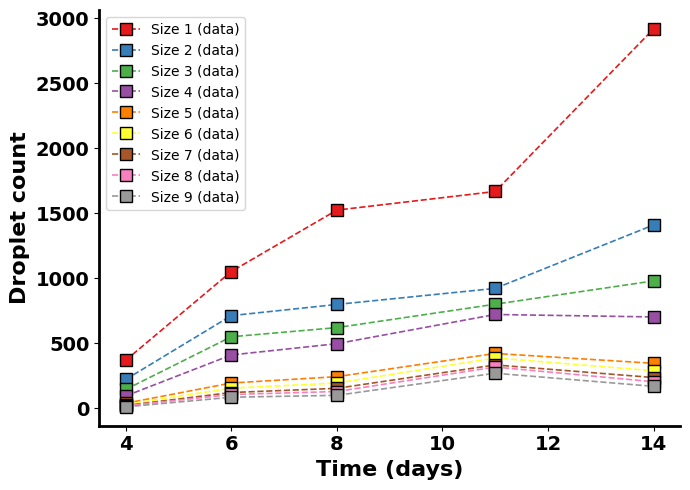

In [5]:
plotter = Plots(base_path='../')
max_size_class_shown = 9
plotter.plot_data_and_model_timecourse(
    model_sol=None, 
    data_array=timecourse_data, 
    max_size_class_shown=max_size_class_shown, 
    fig_size=(7,5))

---

## Section 2) Additive Normal noise model

### Section 2.1) Finding the MLEs

In order to get an initial guess for the parameters, we will try and find the MLEs, $\hat{\theta}$.

To do this, we will use an optimisation routine to find the combination of parameters that maximise the log-likelihood.



##### PINTS model

In [9]:
model = DropletModel(initial_conditions=initial_conditions)

problem = pints.MultiOutputProblem(model, data_times, timecourse_data)

param_mles = {}

##### Log-likelihood

In [7]:
log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    problem, 
    zero_tol=1
)

##### Optimisation

In [8]:
opt_lower_bounds = [0, 0, 0]
opt_upper_bounds = [1e4, 1e-3, 1e0]

opt_bounds = pints.RectangularBoundaries(opt_lower_bounds, opt_upper_bounds)
log_prior = pints.UniformLogPrior(opt_bounds)

opt_initial_position = log_prior.sample(1)

opt = pints.OptimisationController(
    log_likelihood, 
    opt_initial_position, 
    boundaries=opt_bounds, 
    method=pints.XNES
)

opt.set_log_to_screen(True)
opt_params, opt_max_likelihood = opt.run()

print('Estimated parameters:')
print(opt_params)

param_mles["b"] = opt_params[0]
param_mles["f"] = opt_params[1]
param_mles["g"] = opt_params[2]

Maximising LogPDF
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     2     -552.2046 -552.2046   0:00.8
1     5     -552.2046 -552.6675   0:00.8
2     11    -533.2412 -533.2412   0:00.8
3     16    -521.8751 -521.8751   0:00.8
20    122   -498.3196 -498.9177   0:01.0
40    262   -498.0141 -498.0402   0:01.3
60    402   -498.0127 -498.013    0:01.6
80    542   -498.0127 -498.0127   0:01.9
100   682   -498.0126 -498.0126   0:02.2
120   822   -498.0126 -498.0126   0:02.4
140   962   -498.0126 -498.0126   0:02.7
160   1102  -498.0126 -498.0126   0:03.0
180   1242  -498.0126 -498.0126   0:03.2
200   1382  -498.0126 -498.0126   0:03.6
220   1522  -498.0126 -498.0126   0:03.9
240   1662  -498.0126 -498.0126   0:04.2
260   1802  -498.0126 -498.0126   0:04.5
280   1942  -498.0126 -498.0126   0:04.9
300   2082  -498.0126 -498.0126   0:05.2
320   2222  -498.0126 -498.0126   0:05.5
340   2362  -498.0126 

##### Print $\hat{\theta}$

In [9]:
print(opt_params)

[1.48152430e+03 1.52431826e-04 4.42657138e-01]


##### Calculate $\hat{\sigma}$

In [10]:
opt_sigma_mles = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=opt_params,
    data_times=data_times,
    noise_model="additive normal"
)

print(f"{opt_sigma_mles}")

param_mles["sigma_mles"] = opt_sigma_mles

[704.5993627  320.99480565 305.56903389 281.88434952 106.76015419
 107.69735889  93.51835893  94.12985502  77.72753787  70.93172299
  14.66280351  60.14183817  54.63488813  13.30870846  46.12163716
  12.0176629   38.51395683  10.98667487  10.97488124  31.19435314
   9.96643243  25.84644775   8.80589994   8.56378791   8.20413934
  20.06157701   7.30312647   7.0973308    6.6786674   15.5210523
   5.76577425   5.61786794   5.31266385   5.17680283  11.651833
   4.50863997   4.30664989   4.09680777   3.865814     3.74831219
   3.59371937   3.45459572   3.32705847   3.193849     3.10651347
   6.6485471    2.7921408    2.6924615    2.67485074   2.86216743
   7.71621093]


##### Plot the MLE solution

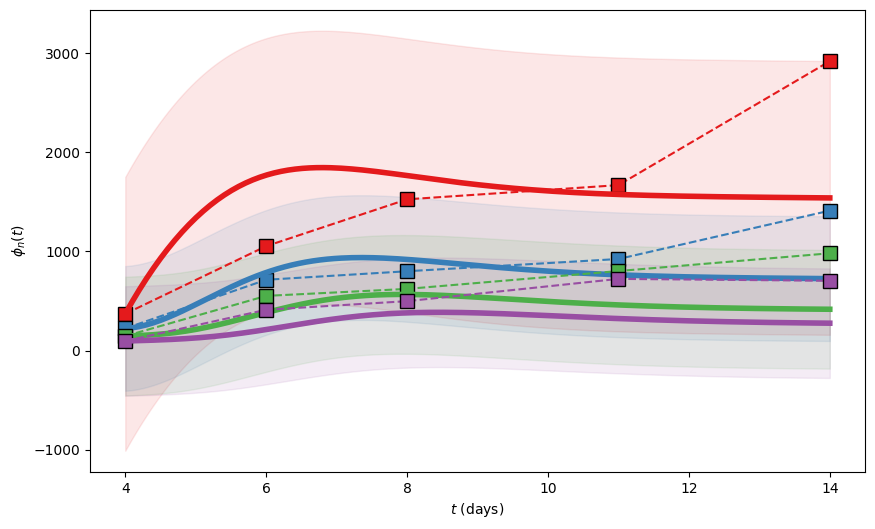

In [11]:
plot_mle_solution(model=model,
                  data=timecourse_data,
                  data_times=data_times,
                  param_mles=param_mles,
                  max_size_shown=4,
                  fig_size=(10,6))

---

### Section 2.2) - Using the MLEs to perform Bayesian inference

##### Get Bayesian chains

In [12]:
b_mle, f_mle, g_mle = param_mles["b"], param_mles["f"], param_mles["g"]
param_mles_model = [b_mle, f_mle, g_mle]

prior_factor = 4
prior_lower_bounds = np.asarray(param_mles_model) / prior_factor
prior_upper_bounds = np.asarray(param_mles_model) * prior_factor

bayesian_chains = get_mcmc_chains(
    log_likelihood=log_likelihood,
    apply_log_transform=True,
    mcmc_method=pints.HaarioBardenetACMC,
    max_mcmc_iterations=20000,
    num_chains=4,
    prior_lower_bounds=prior_lower_bounds,
    prior_upper_bounds=prior_upper_bounds,
    initial_mcmc_points=None,
    log_to_screen=True
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0.5       0.5       0.5        0:00.0
2     12     0         0.667     0.667     0.667      0:00.0
3     16     0.25      0.75      0.5       0.75       0:00.0
20    84     0.429     0.524     0.524     0.476      0:00.2
40    164    0.463     0.537     0.512     0.439      0:00.4
60    244    0.41      0.475     0.41      0.426      0:00.6
80    324    0.382716  0.469     0.382716  0.37       0:00.8
100   404    0.376     0.475     0.376     0.376      0:00.9
120   484    0.372     0.463     0.347     0.338843   0:01.1
140   564    0.383     0.44      0.34      0.348      0:01.3
160   644    0.391     0.441     0.342     0.36       0:01.5
180   724    0.392     0.425     0.337     0.348      0:01.6
Initial phase completed.
200   804    0.388     0.

##### Plot chains trace

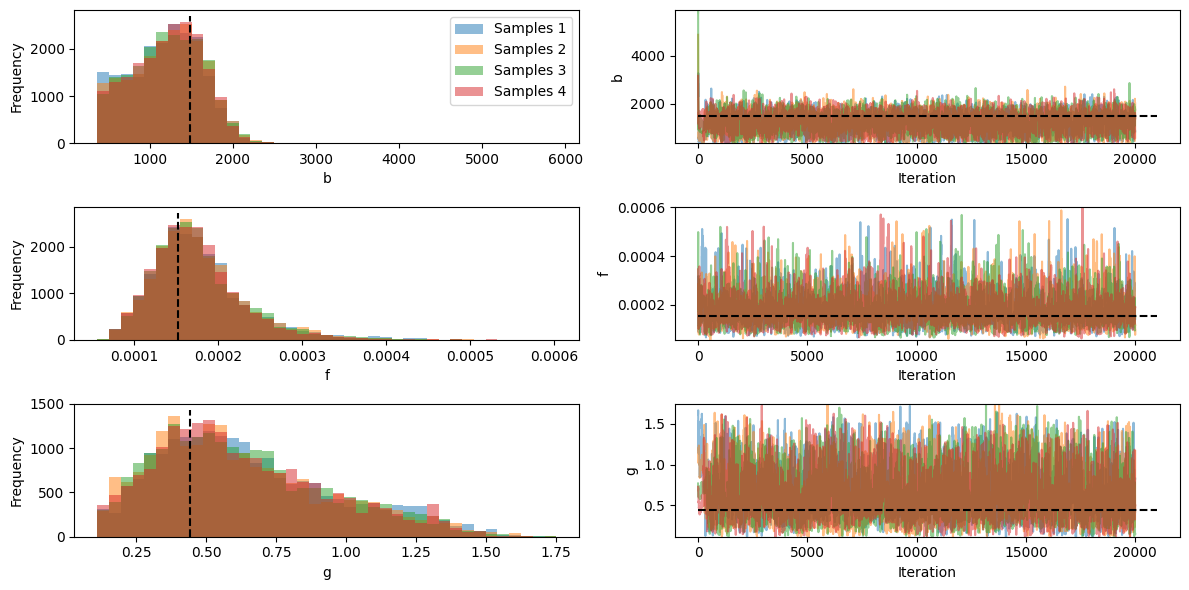

In [13]:
pints.plot.trace(
    bayesian_chains,
    parameter_names=model.param_names,
    ref_parameters=param_mles_model
)
plt.show()

##### Plot chains pairwise distributions

(<Figure size 900x900 with 9 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >],
        [<Axes: ylabel='f'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='b', ylabel='g'>, <Axes: xlabel='f'>,
         <Axes: xlabel='g'>]], dtype=object))

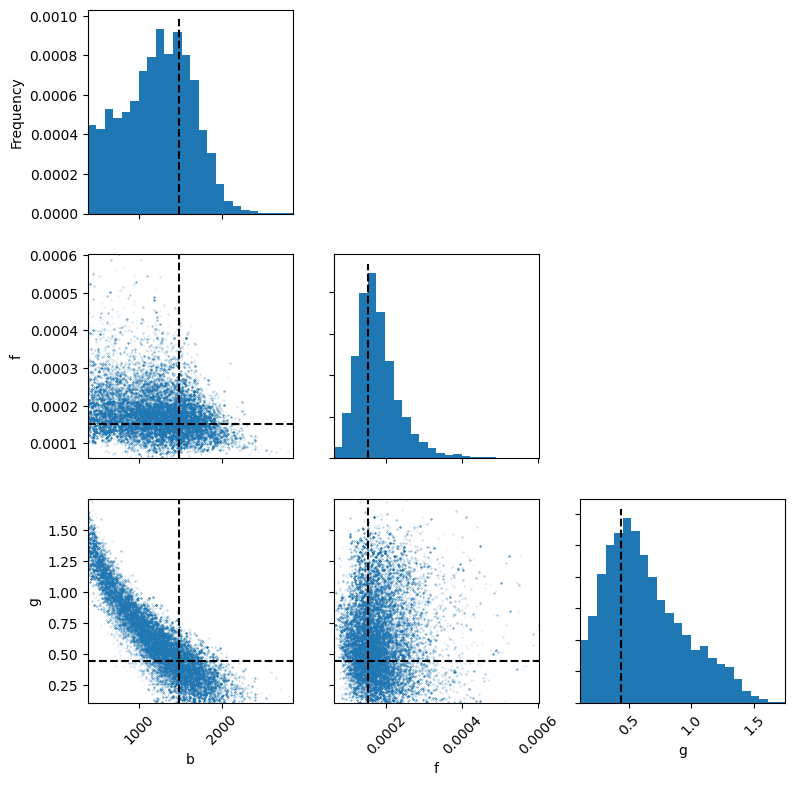

In [14]:
burnt_in_chains = bayesian_chains[:, int(bayesian_chains.shape[1]/2):, :]
stacked_chains = np.vstack(burnt_in_chains)

pints.plot.pairwise(
    stacked_chains, 
    parameter_names=model.param_names,
    ref_parameters=param_mles_model
)

We observe that $b$ and $g$ cannot not be individually identified from this data alone.

##### Posterior predictive check

[1.20794664e+03 1.77841633e-04 6.34056543e-01]


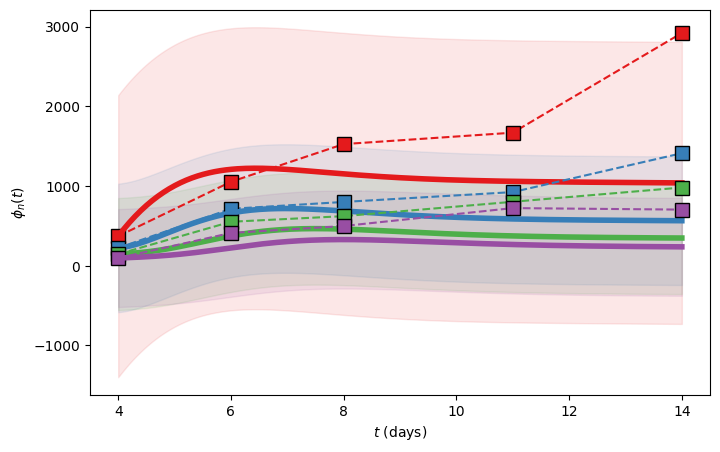

In [16]:
param_maps_model = np.mean(stacked_chains, axis=0)
sigma_maps = get_sigma_MLEs(
    model=model,
    data=timecourse_data,
    mle_params=param_maps_model,
    data_times=data_times
)

param_maps = {
    "b": param_maps_model[0],
    "f": param_maps_model[1],
    "g": param_maps_model[2],
    "sigma_mles": sigma_maps
}


print(param_maps_model)
plot_mle_solution(
    model=model,
    data=timecourse_data,
    data_times=data_times,
    param_mles=param_maps,
    max_size_shown=4
)

##### Plot series

(<Figure size 800x2142.43 with 4 Axes>,
 array([<Axes: ylabel='Output 1'>, <Axes: ylabel='Output 2'>,
        <Axes: ylabel='Output 3'>,
        <Axes: xlabel='Time', ylabel='Output 4'>], dtype=object))

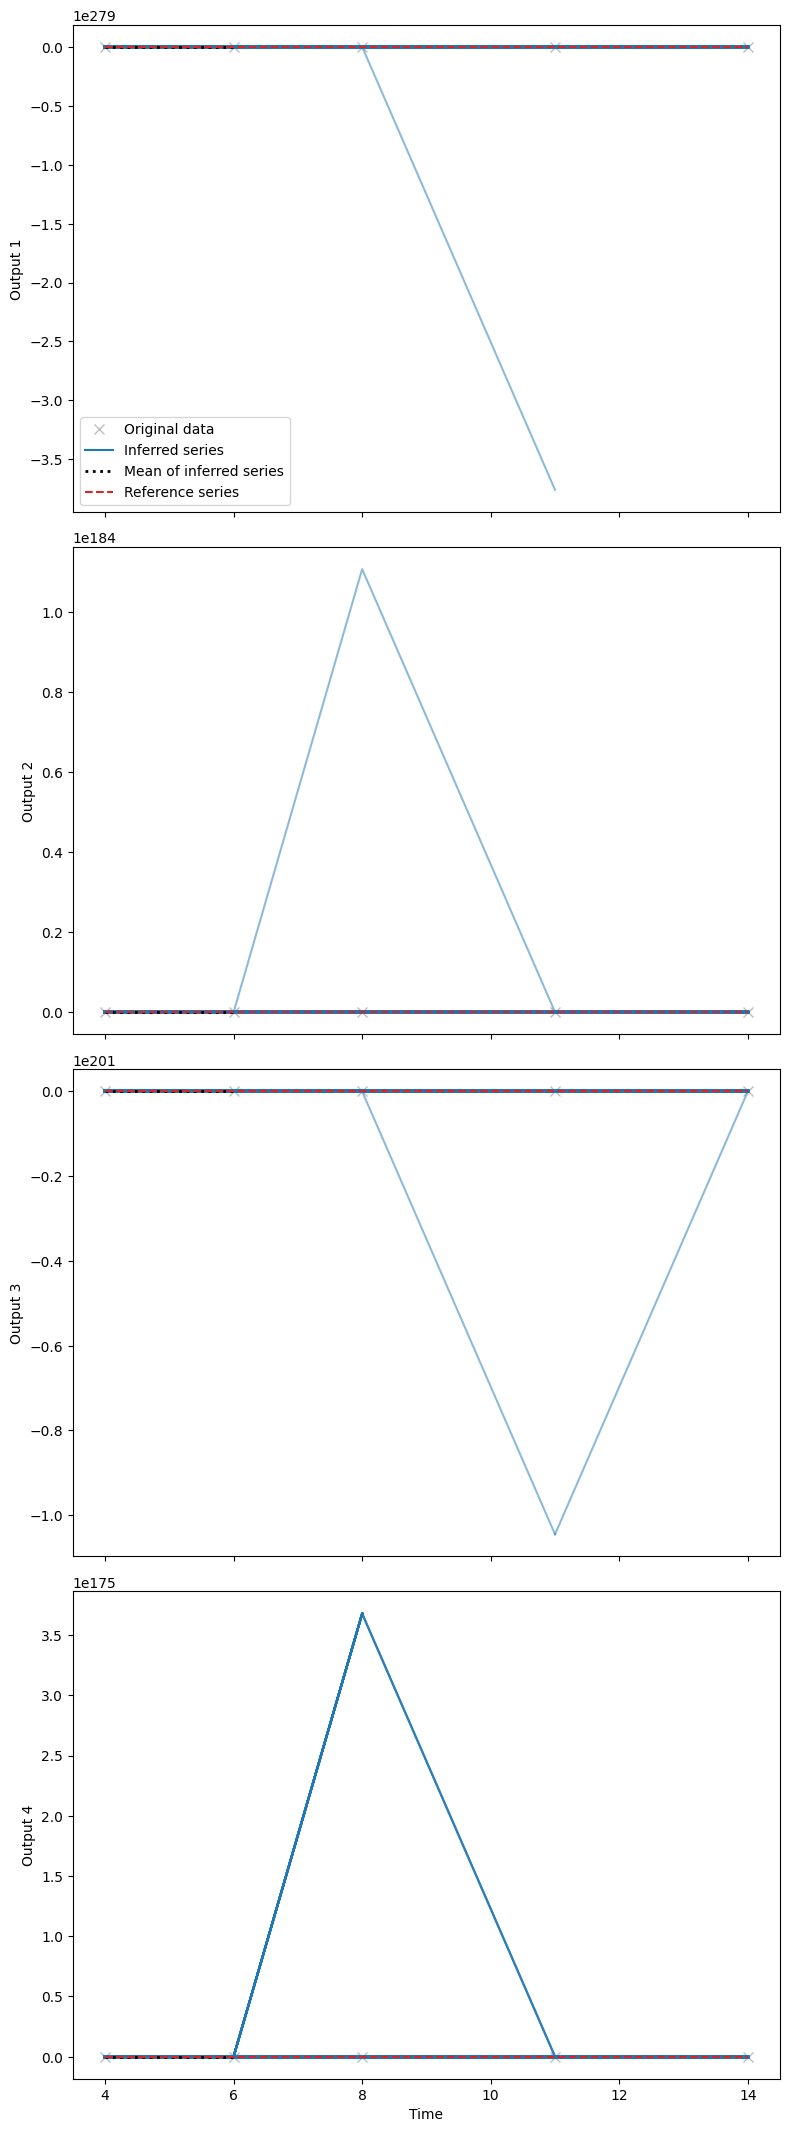

In [17]:
plot_series(stacked_chains, problem=problem, num_ouputs_shown=4, ref_parameters=param_maps_model)

---

### Section 2.3) - MCMC with $b$ fixed

##### Run MCMC

In [31]:
b_fixed_value = 1.48152430e+03

b_fixed_model = DropletModel(
    model_type='fg', 
    initial_conditions=initial_conditions,
    fixed_param_value=b_fixed_value
)

b_fixed_problem = pints.MultiOutputProblem(b_fixed_model, data_times, timecourse_data)

b_fixed_log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    b_fixed_problem, 
    zero_tol=1
)

b_fixed_prior_lower_bounds = [1e-10, 1e-2]
b_fixed_prior_upper_bounds = [1e-3, 1e0]

b_fixed_chains = get_mcmc_chains(
    log_likelihood=b_fixed_log_likelihood,
    apply_log_transform=True,
    max_mcmc_iterations=20000,
    prior_lower_bounds=b_fixed_prior_lower_bounds,
    prior_upper_bounds=b_fixed_prior_upper_bounds
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0.5       0         0.5        0:00.0
2     12     0.333     0.333     0.333     0.667      0:00.0
3     16     0.25      0.5       0.5       0.5        0:00.1
20    84     0.571     0.571     0.762     0.762      0:00.2
40    164    0.659     0.634     0.683     0.561      0:00.4
60    244    0.623     0.541     0.672     0.508      0:00.6
80    324    0.667     0.531     0.605     0.543      0:00.8
100   404    0.683     0.554     0.594     0.495      0:00.9
120   484    0.645     0.545     0.587     0.488      0:01.1
140   564    0.617     0.567     0.582     0.482      0:01.3
160   644    0.64      0.571     0.596     0.497      0:01.5
180   724    0.624     0.58      0.619     0.525      0:01.7
Initial phase completed.
200   804    0.617     0.

##### Diagnostic plots

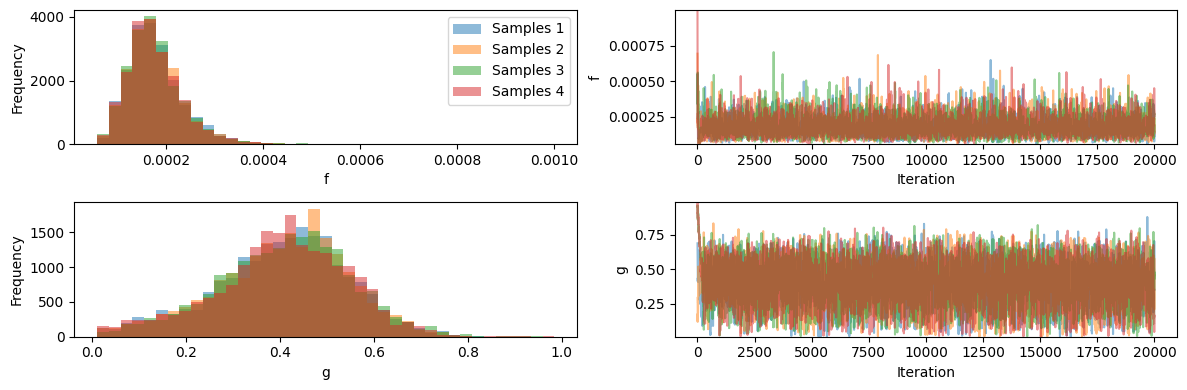

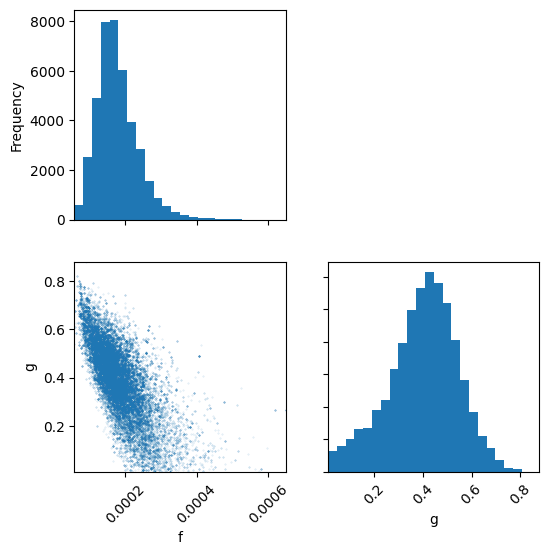

In [32]:
pints.plot.trace(b_fixed_chains, parameter_names=["f", "g"])
plt.show()

burnt_in_b_fixed_chains = b_fixed_chains[:, int(b_fixed_chains.shape[1]/2):, :]
stacked_b_fixed_chains = np.vstack(burnt_in_b_fixed_chains)

pints.plot.pairwise(
    stacked_b_fixed_chains, 
    parameter_names=["f", "g"]
)
plt.show()

##### Plot series using MAPS

MAPS: [1.48152430e+03 1.79000066e-04 3.99871035e-01]


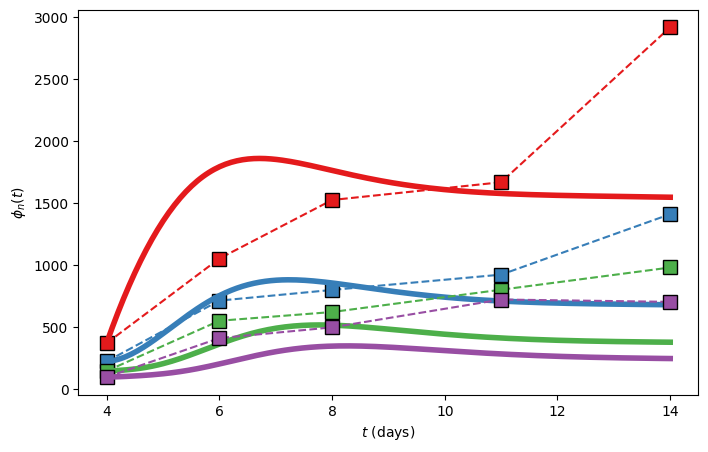

In [42]:
b_fixed_chains_means = np.mean(stacked_b_fixed_chains, axis=0)
b_fixed_maps = np.asarray([b_fixed_value] + list(b_fixed_chains_means))
print(f"MAPS: {b_fixed_maps}")
plot_map_series(
    model=model,
    data=timecourse_data,
    data_times=data_times,
    param_maps=b_fixed_maps,
    max_size_shown=4
)


---

### Section 2.4) - MCMC with $g$ fixed

##### Run MCMC

In [40]:
g_fixed_value = 4.42657138e-01

g_fixed_model = DropletModel(
    model_type='bf', 
    initial_conditions=initial_conditions,
    fixed_param_value=g_fixed_value
)

g_fixed_problem = pints.MultiOutputProblem(g_fixed_model, data_times, timecourse_data)

g_fixed_log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    g_fixed_problem, 
    zero_tol=1
)

g_fixed_prior_lower_bounds = [1e1, 1e-10]
g_fixed_prior_upper_bounds = [1e4, 1e-3]

g_fixed_chains = get_mcmc_chains(
    log_likelihood=g_fixed_log_likelihood,
    apply_log_transform=True,
    max_mcmc_iterations=20000,
    prior_lower_bounds=g_fixed_prior_lower_bounds,
    prior_upper_bounds=g_fixed_prior_upper_bounds
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0.5       0         0          0:00.0
2     12     0.333     0.667     0.333     0          0:00.0
3     16     0.5       0.5       0.25      0          0:00.1
20    84     0.524     0.333     0.333     0.19       0:00.2
40    164    0.439     0.317     0.341     0.22       0:00.4
60    244    0.393     0.295082  0.426     0.262      0:00.6
80    324    0.382716  0.259     0.407     0.272      0:00.8
100   404    0.347     0.287     0.396     0.297      0:00.9
120   484    0.372     0.289     0.355     0.298      0:01.1
140   564    0.369     0.305     0.355     0.312      0:01.3
160   644    0.373     0.310559  0.354     0.304      0:01.5
180   724    0.37      0.304     0.359116  0.293      0:01.7
Initial phase completed.
200   804    0.353     0.

##### Diagnostic plots

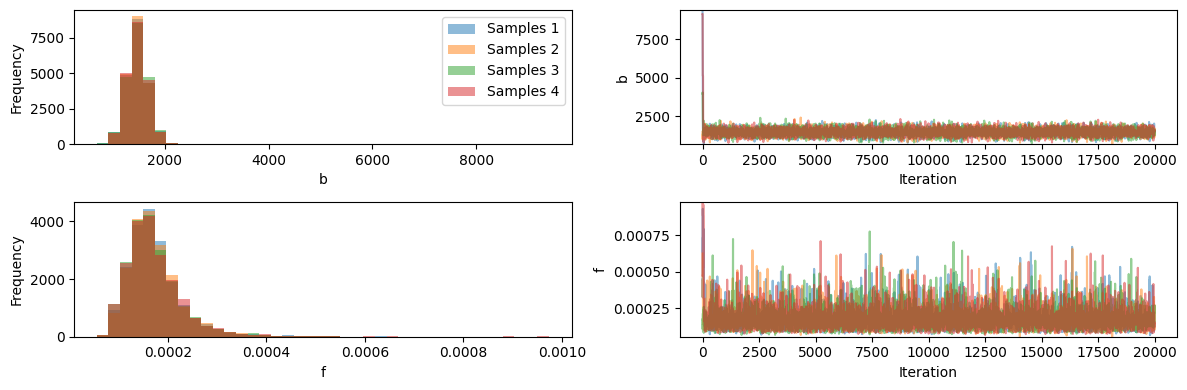

(<Figure size 600x600 with 4 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >],
        [<Axes: xlabel='b', ylabel='f'>, <Axes: xlabel='f'>]], dtype=object))

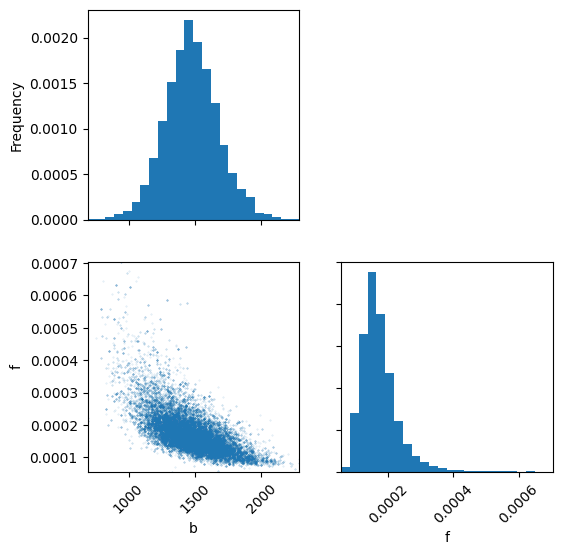

In [41]:
pints.plot.trace(g_fixed_chains, parameter_names=["b", "f"])
plt.show()

burnt_in_g_fixed_chains = g_fixed_chains[:, int(g_fixed_chains.shape[1]/2):, :]
stacked_g_fixed_chains = np.vstack(burnt_in_g_fixed_chains)

pints.plot.pairwise(
    stacked_g_fixed_chains, 
    parameter_names=["b", "f"]
)

##### Plot series using MAPS

MAPS: [1.47471397e+03 1.72641919e-04 4.42657138e-01]


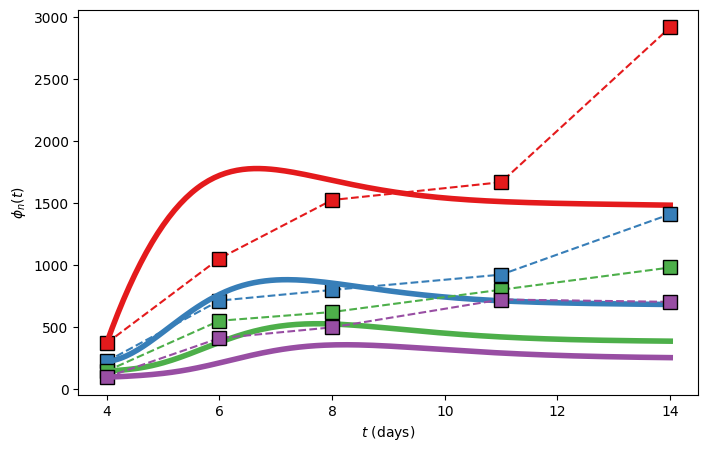

In [45]:
g_fixed_chains_means = np.mean(stacked_g_fixed_chains, axis=0)
g_fixed_maps = np.asarray(list(g_fixed_chains_means) + [g_fixed_value])
print(f"MAPS: {g_fixed_maps}")
plot_map_series(
    model=model,
    data=timecourse_data,
    data_times=data_times,
    param_maps=g_fixed_maps,
    max_size_shown=4
)

---

### Section 2.5) -  Re-parameterise, and infer $b = \alpha + \beta \, g$

##### Re-parameterised model MCMC

In [ ]:
reparameterised_model = ReparameterisedDropletModel(initial_conditions=initial_conditions)

reparameterised_problem = pints.MultiOutputProblem(reparameterised_model, data_times, timecourse_data)

reparameterised_log_likelihood = AdditiveNormalSigmaMLEIndicatorLogLikelihood(
    reparameterised_problem, 
    zero_tol=1
)
print(reparameterised_model.param_names)

print(reparameterised_log_likelihood.n_parameters())

reparameterised_prior_lower_bounds = [0, -1e4, 1e-10, 1e-2]
reparameterised_prior_upper_bounds = [1e4, 1e4, 1e-3, 1e0]

reparameterised_chains = get_mcmc_chains(
    log_likelihood=reparameterised_log_likelihood,
    apply_log_transform=True,
    max_mcmc_iterations=20000,
    prior_lower_bounds=reparameterised_prior_lower_bounds,
    prior_upper_bounds=reparameterised_prior_upper_bounds
)

['u', 'v', 'f', 'g']
4
Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.9
1     8      0.5       0         0         0.5        0:00.9
2     12     0.333     0         0         0.333      0:00.9
3     16     0.5       0         0         0.25       0:00.9
20    84     0.619     0.381     0.429     0.429      0:01.1
40    164    0.561     0.512     0.293     0.39       0:01.2
60    244    0.426     0.508     0.213     0.393      0:01.4
80    324    0.432     0.494     0.235     0.42       0:01.6
100   404    0.406     0.455     0.218     0.396      0:01.7
120   484    0.405     0.446281  0.214876  0.388      0:01.9
140   564    0.376     0.454     0.234     0.39       0:02.1
160   644    0.385     0.447205  0.224     0.391      0:02.3
180   724    0.365     0.459     0.232     0.376      0:02.4
Initial phase completed.
20

##### Diagnostic plots

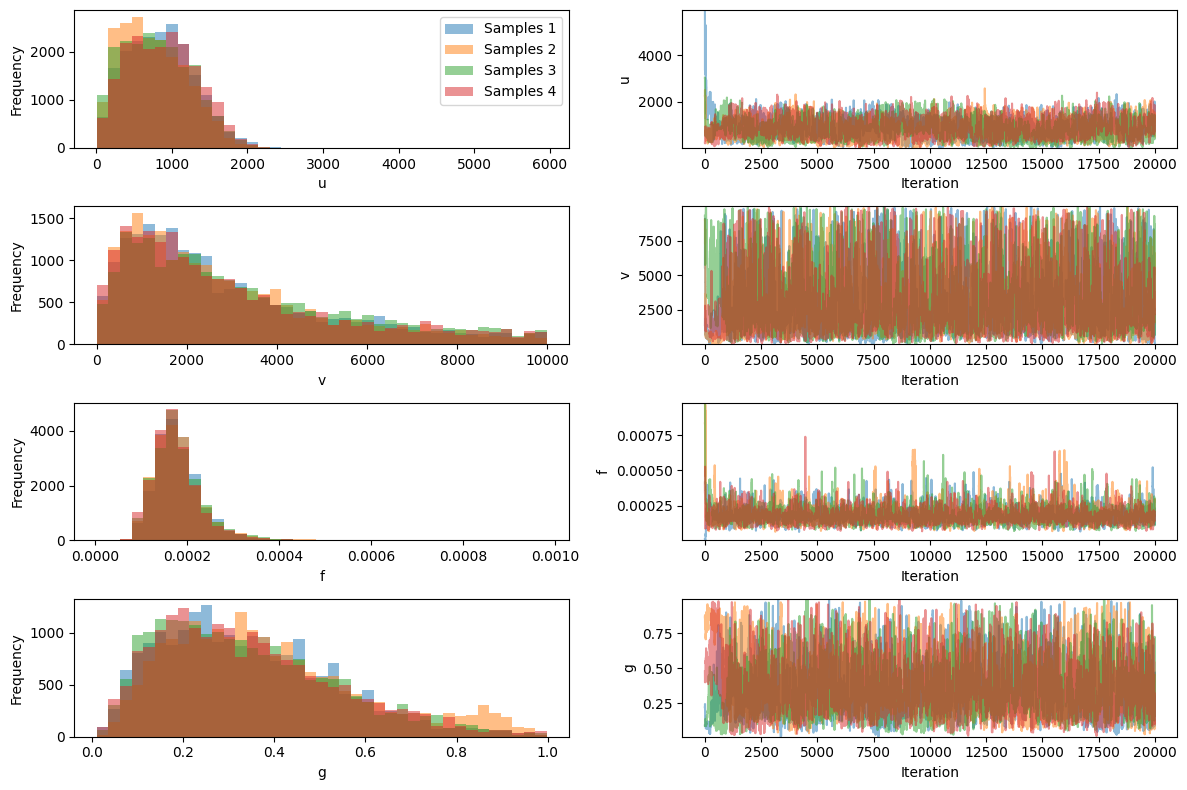

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='v'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='f'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='u', ylabel='g'>, <Axes: xlabel='v'>,
         <Axes: xlabel='f'>, <Axes: xlabel='g'>]], dtype=object))

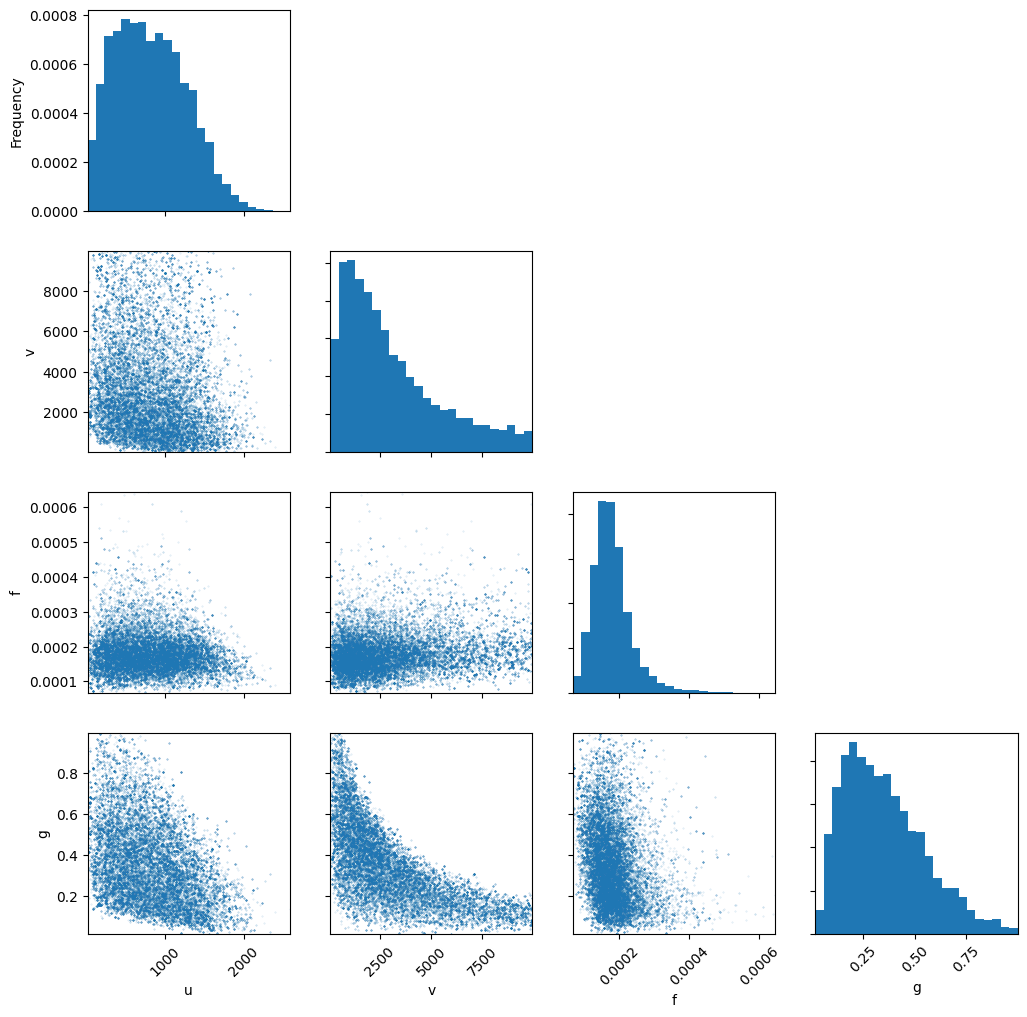

In [7]:
pints.plot.trace(reparameterised_chains, parameter_names=["u", "v", "f", "g"])
plt.show()

burnt_in_reparameterised_chains = reparameterised_chains[:, int(reparameterised_chains.shape[1]/2):, :]
stacked_reparameterised_chains = np.vstack(burnt_in_reparameterised_chains)

pints.plot.pairwise(
    stacked_reparameterised_chains, 
    parameter_names=["u", "v", "f", "g"]
)

##### Plot series using MAPS

MAPS: [1.88730982e+03 1.79925330e-04 3.50742906e-01]


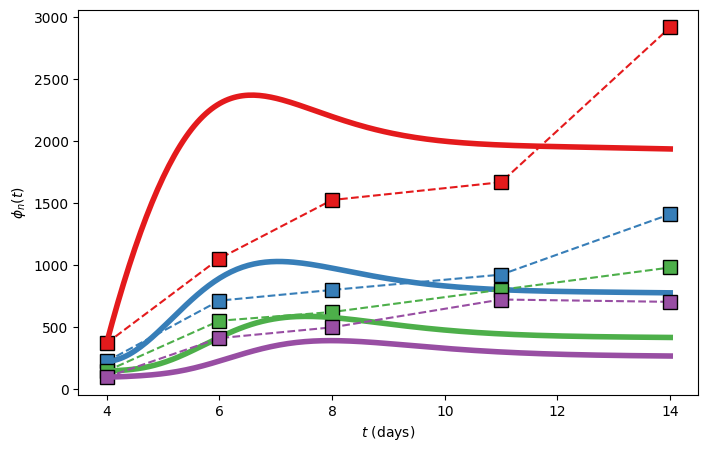

In [11]:
reparameterised_chains_means = np.mean(stacked_reparameterised_chains, axis=0)
u_mean = reparameterised_chains_means[0]
v_mean = reparameterised_chains_means[1]
f_mean = reparameterised_chains_means[2]
g_mean = reparameterised_chains_means[3]
b_mean = u_mean + v_mean * g_mean
reparameterised_maps = np.asarray([b_mean, f_mean, g_mean])
print(f"MAPS: {reparameterised_maps}")
plot_map_series(
    model=model,
    data=timecourse_data,
    data_times=data_times,
    param_maps=reparameterised_maps,
    max_size_shown=4
)